# Introduction to Machine Learning: Text Analysis and Text as Data

In [1]:
# import libraries used in this notebook
import re
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import spacy
import en_core_web_sm
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
%matplotlib inline

from string import punctuation
from tqdm import tqdm

import gensim
from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

import multiprocessing

C:\Users\Anike\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Anike\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Anike\anaconda3\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
C:\Users\Anike\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Introduction

<center>
    <img src = "https://github.com/Akesari12/Computational-Social-Science-Training-Program/blob/master/images/cfpb%20logo.png?raw=true"  />
</center>

The CFPB dataset is a collection of complaints filed by consumers against financial institutions. The dataset contains a number of features, including the text of the complaint, the product type, and the company the complaint was filed against. The full dataset is available at https://www.consumerfinance.gov/data-research/consumer-complaints/. This dataset is convenient for text analysis because the consumer complaints are real text generated by real people - and have all the idiosyncrasies that come with that process. It also contains multiple different categories that we can predict, like type of product the complaint is about and whether the complaint was resolved quickly. The basic process is that if someone has a dispute related to consumer finance (mortgages, student loans, credit cards, etc.), they can file a dispute with the CFPB, which then contacts the company named in the dispute to get some resolution of the issue.

We will use this dataset to explore the entire text analysis and machine learning pipeline. Specifically we will:

1. Represent text as tokens and matrices to prepare them for machine learning
2. Engineer additional text features like topic codes and sentiments with unsupervised learning techniques
3. Use Supervised Learning to predict the "Product" category based on the text

Notice how this notebook is full of comments. Much of the code here was generated with Github CoPilot! If you enjoy using ChatGPT to generate code, consider integrating it directly into your notebooks with this tool.

In [2]:
## load 2023 complaints data from data folder as CFPB_2023
cfpb = pd.read_csv('./data/CFPB Complaints 2023.csv')
#url = 'https://github.com/Akesari12/mpi_summer_school/raw/main/data/CFPB%20Complaints%202023.csv'

#cfpb = pd.read_csv(url)

# Drop observations with missing data in the 'Consumer complaint narrative' column and reset index
cfpb = cfpb.dropna(subset=['Consumer complaint narrative']).reset_index(drop=True)

# look at the first 5 rows of cfpb
cfpb.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_received
0,0,2023-07-22,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,Money is being held with out my permission. Ca...,NaN,Chime Financial Inc,CA,95678,NaN,Consent provided,Web,2023-07-22,Closed with explanation,Yes,NaN,7291298,2023
1,1,2023-07-22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I do not have any knowledge of applying for a ...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,AZ,85741,NaN,Consent provided,Web,2023-07-22,Closed with non-monetary relief,Yes,NaN,7291403,2023
2,2,2023-08-29,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"Seriously, it's been months since I investigat...",Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NJ,07087,NaN,Consent provided,Web,2023-08-29,Closed with non-monetary relief,Yes,NaN,7460791,2023
3,3,2023-08-29,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,I have been trying to dispute incorrect and/or...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85013,NaN,Consent provided,Web,2023-08-29,Closed with non-monetary relief,Yes,NaN,7463275,2023
4,4,2023-07-17,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Received unwanted marketing or advertising,It shows that a mortgage company pulled my cre...,NaN,"EQUIFAX, INC.",NC,27292,NaN,Consent provided,Web,2023-07-17,Closed with explanation,Yes,NaN,7264416,2023


In [3]:
# Show some descriptive statistics for the product, issue, company response to consumer, timely response, and consumer disputed columns, but ignore NAs in each column
cfpb[['Product', 'Issue', 'Company response to consumer', 'Timely response?']].describe()

,Product,Issue,Company response to consumer,Timely response?
count,298530,298530,298530,298530
unique,14,85,5,2
top,"Credit reporting, credit repair services, or o...",Incorrect information on your report,Closed with explanation,Yes
freq,211354,84770,185752,296878


In [4]:
# Check the first 10 rows of the consumer complaint narrative column and print the full text of each with a number next to each complaint
for i in range(10):
    print(i, cfpb['Consumer complaint narrative'][i])

0 Money is being held with out my permission. Causing me to have pain and suffering for me and my daughter. Horrible customer service and rude employees lie about the policy and does not follow it. I am having a horrible experience with chime and it needs to be resolved.
1 I do not have any knowledge of applying for a credit card with XXXX. Nor do I have a contract with the debt collector. I demand this inquiry be removed from my credit report.
2 Seriously, it's been months since I investigated my credit report, and I realized that some of the information was still erroneous. The 3 credit bureaus are required to authenticate these items under Sections 609 ( a ) ( 1 ) ( A ) and 611 ( a ) ( 1 ). ( A ). It is not acceptable to treat these reporting items as unconfirmed information without producing proof within the legal time range. Sections 609 ( a ) ( 1 ) ( A ) and 611 ( a ) ( 1 ). ( A ), Please investigate the unverifiable items and remove them immediately from my report XXXX XXXX XXXX

In [5]:
# Subset cfpb so that Product is one of 'Money transfer, virtual currency, or money service' or 'Vehicle loan or lease
cfpb = cfpb[cfpb['Product'].isin(['Debt collection', 'Credit card or prepaid card'])].reset_index(drop=True)
cfpb['Product'].value_counts()

Debt collection                22309
Credit card or prepaid card    19948
Name: Product, dtype: int64

<center>
    <img src = "https://github.com/Akesari12/CELS-ML-Text-Analysis-Workshop/blob/main/images/ml_workflow.png?raw=true"  />
</center>

The typical machine learning workflow involves data collection, processing, training models, testing models, and deploying models. We took care of the data collection part, and now will focus on some techniques for cleaning, training, and evaluating machine learning models for text analysis.

# Step 1: Text Featurization Using spaCy

Text needs to be represented numerically before it can be used in a machine learning pipeline. We will cover some of the basic building blocks for:

1. Representing text as "tokens"
2. Creating matrices that count and scale how often words occur in a corpus of text

## 1.1 Stemming, Lemmatization, and Chunking

#### 1.1.1 Tokenization

The basic unit of analysis in text analysis is the **token**, which is a numerical representation of text. Imagine we are trying to build a puzzle. Each "token" represents a piece of the puzzle, and can correspond to different sizes (like paragraphs, sentences, or words). 

Let's see how we tokenize in practice. spaCy uses pre-trained language models to incorporate context when creating tokens. In this case, we'll load the [en_core_web_sm](https://spacy.io/models/en), which is one of spaCy's English language models. 

Consider the sentence: "Last year, the average cost of a coffee cup in the U.S.A was $5.89." Splitting on punctuation would yield a token list like:

[Last, year, the, average, cost, of, a, coffee, cup, in, the, U, S, A, was, $5, 89]

Most of these tokens look pretty good, but we get some errors like splitting "USA" into three separate tokens and spltting \$5.89 into \\$5 and 89. 

spaCy helps [solve this problem](https://spacy.io/usage/spacy-101#annotations-token) by going through the following steps:

First, the raw text is split on whitespace characters, similar to `text.split(' ')`. Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

1. Does the substring match a tokenizer exception rule? For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.S.A” should always remain one token.
2. Can a prefix, suffix or infix be split off? For example punctuation like commas, periods, hyphens or quotes.

If there’s a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks.

Now let's try applying these methods to our CFPB data. The steps to do this are:

1. Load the language model.
2. Apply it to a piece of text and save it in an spaCy "doc" object.
3. Extract each token from the doc object to a list.
4. Display the tokens

Let's do this for our first observation in our dataframe:

In [6]:
# save the first cfpb consumer complaint as "text"
text = cfpb['Consumer complaint narrative'][0]

# load the spaCy language model
nlp = en_core_web_sm.load()

# Apply it to a piece of text and save it in a spaCy "doc" object
doc = nlp(text)

# Extract each token from the doc object to a list
spacy_words = [token.text for token in doc]

# Display the tokens
display(f"Tokenized words: {spacy_words}")

"Tokenized words: ['Money', 'is', 'being', 'held', 'with', 'out', 'my', 'permission', '.', 'Causing', 'me', 'to', 'have', 'pain', 'and', 'suffering', 'for', 'me', 'and', 'my', 'daughter', '.', 'Horrible', 'customer', 'service', 'and', 'rude', 'employees', 'lie', 'about', 'the', 'policy', 'and', 'does', 'not', 'follow', 'it', '.', 'I', 'am', 'having', 'a', 'horrible', 'experience', 'with', 'chime', 'and', 'it', 'needs', 'to', 'be', 'resolved', '.']"

### 1.1.2 Removing Stop Words and Punctuation

We now have some tokens with just a few lines of code! There are a few additional steps that we might want to take. For example, we may want to remove punctuation and stop words. Punctuation oftentimes does not add substantive information to a piece of text, and stop words are common words that appear very frequently across texts. Removing this kind of information can help with downstream classification tasks by allowing an algorithm to focus on words that distinguish documents, rather than ones that appear frequently across them. 

First, let's take a look at stop words. We can start by importing a collection of stop words from spaCy by running the following code:

In [7]:
# import stop words and look at the 10 most common ones
from spacy.lang.en.stop_words import STOP_WORDS
print(list(STOP_WORDS)[0:10])

['’ll', 'it', 'everything', 'you', 'enough', 'never', 'more', 'something', 'thus', 'out']


We can do the same for punctuation:

In [8]:
# import punctuation
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Removing punctuation and stop words is not a hard and fast rule - there may be situations where you want to keep them. In most applications, they add noise to downstream tasks, but always be mindful of your particular application when making decisions. Now that we have some tokenization tools, let's put them all together in a function!

#### Challenge: Write a function that takes a piece of text as an argument, and returns a list of tokens without punctuation or stop words.

In [9]:
# Write a function, with comments, `rem_punc_stop` that takes the argument `text` and returns a list of tokens that are free of punctuation and stop words.
def rem_punc_stop(text):
    # create a spaCy doc object
    doc = nlp(text)
    # create a list of tokens from the doc object
    tokens = [token.text for token in doc]
    # create a list of tokens that are not stop words or punctuation
    tokens_reduced = [token for token in tokens if (token not in STOP_WORDS) and (token not in punctuation)]
    # return the list of tokens
    return tokens_reduced


# test rem_punc_stop with the text from the first cfpb complaint and save the result in tokens_reduced
tokens_reduced = rem_punc_stop(text)
tokens_reduced[0:10]

['Money',
 'held',
 'permission',
 'Causing',
 'pain',
 'suffering',
 'daughter',
 'Horrible',
 'customer',
 'service']

### 1.1.3 Lemmatization

Another preprocessing step we might take is reducing words down to their lemmas. Lemmatization reduces a word to its root word, while making sure the word still belongs to the language. Consider the following example:

In [10]:
# write code that goes through the string 'compute computer computed computing' and prints the text and lemma
doc = nlp('compute computer computed computing')
for token in doc:
    print(token.text, token.lemma_)

compute compute
computer computer
computed compute
computing computing


### Bag of Words/Tf-idf

How do we go from tokens to making predictions with text? Supervised machine learning applications will generally have a `target` to be predicted and `features` used to make that prediction. These are the equivalents of the `dependent variable`/`response variable`/`outcome` and `independent variables`/`explanatory variables`/`covariates` in machine learning terms. There are many options for converting raw text into `features`. We will start with **bag of words**, one of the simplest ways to represent tokens as counts. Consider the following toy example:

| Product                        | money | harass | social | Visa | credit |
|--------------------------------|-------|--------|--------|------|--------|
| Debt or Debt Collection        | 5     | 7      | 2      | 0    | 4      |
| Credit card or prepaid card    | 3     | 1      | 3      | 5    | 6      |
| Credit card or prepaid card    | 4     | 0      | 1      | 0    | 3      |
| Debt or Debt Collection        | 2     | 1      | 0      | 0    | 2      |
| Debt or Debt Collection        | 1     | 2      | 3      | 0    | 1      |


In this data, each row is a separate consumer complaint. *Product* is the target we want to predict, and each column represents a token. Each cell represents how many times that token appears in that document.

Let's see how we do this with code. We'll import the CounterVectorizer method from sklearn, then use the tokenizer function that we wrote earlier to initialize the CountVectorizer.

In [11]:
# initialize CounterVectorizer then use rem_punc_stop as the tokenizer and save as bow_vector
bow_vector = CountVectorizer(tokenizer=rem_punc_stop)

Once we create a CountVectorizer object, we can then transform a list of texts with the "fit_transform" method. This will return a sparse matrix with the counts. We can densify the matrix (store non-zero values and their positions) with the ".todense()" method.

In [12]:
# fit bow_vector to the first 5 complaints in cfpb['Consumer complaint narrative'] and save as bow_matrix
bow_matrix = bow_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])

C:\Users\Anike\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
# densify bow_matrix and save as bow_matrix_dense
bow_matrix_dense = bow_matrix.todense()
bow_matrix_dense

matrix([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  1,  0,  0],
        [ 0,  0,  3, ..., 13,  1,  1],
        [ 0,  1,  0, ...,  3,  0,  0],
        [ 1,  0,  0, ..., 10,  0,  0]], dtype=int64)

We can also get the feature names:

In [14]:
# get the feature names from bow_vector and print the first 50
feature_names = bow_vector.get_feature_names_out()
feature_names[0:50]

array(['\n', '\n\n', ' ', '1', '10', '100', '2300.00', '460.00', '5',
       '890.00', 'account', 'additional', 'admitted', 'advise',
       'affected', 'agency', 'aggressively', 'aging', 'agreed', 'america',
       'apologetically', 'apologized', 'approached', 'asked', 'asking',
       'assist', 'association', 'assured', 'attempted', 'auto', 'away',
       'balance', 'bank', 'behalf', 'believe', 'belligerent', 'berated',
       'better', 'bill', 'boa', 'brought', 'bureau', 'business', 'called',
       'car', 'card', 'causing', 'certainly', 'change', 'charge'],
      dtype=object)

### Term Frequency - Inverse Document Frequency

An extension of bag-of-words is the term frequency-inverse document frequency approach. Whereas bag-of-words counts the number of words in the document. tf-idf takes this quanity and divides it by how frequently the word shows up across the corpus. In notation:

$TF-IDF(t,d)=TF(t,d)×IDF(t)$

Where:

* $TF(t,d)$ is term frequency of term $t$ in document $d$ (number of times a token appears in that consumer complaint)
* $IDF(f) = log(\frac{N}{DF(t)}$ is the inverse document frequency (where $N$ is number of documents, $DF(t)$ is the number of documents containing term $t$). (Log of number of consumer complaints/number of consumer complaints containing a token)

In doing so, the tf-idf score downweights words that are common in the corpus and thus would not aid with classification. Our toy example from before would look like this:

| Product      | money |   harass |   social |     Visa | credit |
|-------|-------|----------|----------|----------|--------|
| Debt or Debt Collection |   0.0 | 1.562005 | 0.446287 |  0.00000 |    0.0 |
| Credit card or prepaid card |   0.0 | 0.223144 | 0.669431 |  8.04719 |    0.0 |
| Credit card or prepaid card |   0.0 | 0.000000 | 0.223144 |  0.00000 |    0.0 |
| Debt or Debt Collection |   0.0 | 0.223144 | 0.000000 |  0.00000 |    0.0 |
| Debt or Debt Collection |   0.0 | 0.446287 | 0.669431 |  0.00000 |    0.0 |


**Challenge: Using the code from the "Bag of Words" section as a template, write code to get the tf-idf matrix for the CFPB data.**

In [15]:
# initialize TfidfVectorizer then use rem_punc_stop as the tokenizer and save as tfidf_vector
tfidf_vector = TfidfVectorizer(tokenizer=rem_punc_stop)

# fit tfidf_vector to the first 5 complaints in cfpb['Consumer complaint narrative'] and save as tfidf_matrix
tfidf_matrix = tfidf_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])

# get the feature names from tfidf_vector, make a dataframe with the features names and tf-idf counts, and show the first 50 columns
feature_names = tfidf_vector.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)
tfidf_df.iloc[:, 0:50]

,\n,\n\n,,1,10,100,2300.00,460.00,5,890.00,...,brought,bureau,business,called,car,card,causing,certainly,change,charge
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.211753,0.000000,0.000000,0.000000
1,0.000000,0.00000,0.000000,0.054297,0.054297,0.000000,0.00000,0.054297,0.054297,0.00000,...,0.108594,0.043806,0.054297,0.00000,0.054297,0.175225,0.000000,0.000000,0.108594,0.054297
2,0.000000,0.00000,0.182822,0.000000,0.000000,0.121882,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.049167,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.10469,0.000000,0.000000,0.000000,0.000000,0.10469,0.000000,0.000000,0.10469,...,0.000000,0.000000,0.000000,0.10469,0.000000,0.084464,0.000000,0.000000,0.000000,0.000000
4,0.108176,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.108176,0.000000,0.000000


# Step 2: Feature Engineering

What if we want features that capture more information than just word counts? We will explore a few options for doing this:

1. Topic Models
2. Sentiment Analysis

## Topic Models

Machine learning can be divided into `supervised learning` or `unsupervised learning`. Supervised learning uses labeled data to map inputs to outputs (e.g. predict a Product category based on features in the CFPB dataset), whereas unsupervised learning finds patterns in unlabeled data (e.g. finds geographic clusters of "medical debt" complaints in the CFPB dataset).

One popular unsupervised method for text is the [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), or topic modeling. Topic models can help us uncover structure within a text. Specifically it does so through a "mixture model" - meaning every document is assumed to be "about" various topics, and we try to estimate the proportion each topic contributes to a document.

Let's apply a LDA model. The key hyperparameter here is the `n_components` argument. Let's start with 5, and then print out our topics to see what we get.

In [16]:
N_TOPICS = 5 # choose the number of topics

# initialize LatentDirichletAllocation with 5 topics, 20 iterations, and a random state of 0, then fit it to tfidf_matrix
lda = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=20, random_state=0)
lda = lda.fit(tfidf_matrix)

In [17]:
# print the top 10 words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic 0:
xxxx debt contacted work shop xx financial patient reached refund
Topic 1:
xxxx xx debt credit net closed opened reporting report account
Topic 2:
sent account xx balance told service follow proof xxxx problem
Topic 3:
payment saying received posted date provide milestone confirmation xxxx sent
Topic 4:
horrible daughter resolved policy permission pain suffering needs money rude


## Topic weights

One thing we may want to do with the output is compare the prevalence of each topic across documents. A simple way to do this, is to merge the topic distribution back into the Pandas dataframe.

First get the topic distribution array.

In [18]:
# Find the distribution of each topic across documents by merging the topic distribution into the original cfpb dataframe and call it cfpb_topics
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist, columns=[f"topic_{i}" for i in range(N_TOPICS)])
cfpb_topics = topic_dist_df.join(cfpb.reset_index())
cfpb_topics.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,index,Unnamed: 0,Date received,Product,Sub-product,...,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_received
0,0.037337,0.037338,0.037343,0.037337,0.850645,0,0,2023-07-22,Credit card or prepaid card,General-purpose credit card or charge card,...,95678,NaN,Consent provided,Web,2023-07-22,Closed with explanation,Yes,NaN,7291298,2023
1,0.928547,0.017873,0.017859,0.017875,0.017846,1,8,2023-08-12,Credit card or prepaid card,General-purpose credit card or charge card,...,33325,NaN,Consent provided,Web,2023-08-12,Closed with explanation,Yes,NaN,7389759,2023
2,0.888354,0.028043,0.027830,0.027896,0.027877,2,15,2023-07-20,Debt collection,Medical debt,...,498XX,NaN,Consent provided,Web,2023-07-20,Closed with non-monetary relief,Yes,NaN,7279944,2023
3,0.030647,0.030686,0.030409,0.877859,0.030400,3,17,2023-07-17,Debt collection,Credit card debt,...,67212,NaN,Consent provided,Web,2023-07-17,Closed with explanation,Yes,NaN,7261717,2023
4,0.038024,0.848590,0.037771,0.037852,0.037763,4,18,2023-07-21,Debt collection,Payday loan debt,...,30236,NaN,Consent provided,Web,2023-07-21,Closed with explanation,Yes,NaN,7286377,2023


Now we can check the average weight of each topic across Product using `groupby`.

In [19]:
# check the average weight of each topic across Product by using groupby
grouped = cfpb_topics.groupby('Product')
for i in range(0, N_TOPICS):
    print(grouped[f"topic_{i}"].mean().sort_values(ascending=False))

Product
Credit card or prepaid card    0.482942
Debt collection                0.319009
Name: topic_0, dtype: float64
Product
Debt collection                0.302440
Credit card or prepaid card    0.027605
Name: topic_1, dtype: float64
Product
Debt collection                0.032003
Credit card or prepaid card    0.027601
Name: topic_2, dtype: float64
Product
Debt collection                0.314535
Credit card or prepaid card    0.027606
Name: topic_3, dtype: float64
Product
Credit card or prepaid card    0.434246
Debt collection                0.032013
Name: topic_4, dtype: float64


### Sentiment Polarity

A common area of research in the social sciences is thinking about the "sentiment" of a text. The [`TextBlob`](https://textblob.readthedocs.io/en/dev/quickstart.html) library gives us access to a pre-trained sentiment analysis model. Text might be characterized as "positive," "negative," or "neutral" on a [-1,1] scale with -1 being highly negative and 1 being highly positive. Before we look at the code, do you expect that the sentiment scores for these data should be negative or positive? 

In [20]:
# take cfpb, take just the first 5 rows and call cfpb_sample, create a column ['tokens'] that uses rem_punc_stop to tokenize, join the list of tokens
cfpb_sample = cfpb[0:1000]
cfpb_sample['tokens'] = cfpb_sample['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
cfpb_sample['tokens'] = cfpb_sample['tokens'].map(lambda text: ' '.join(text))

<ipython-input-20-056b32d8f504>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfpb_sample['tokens'] = cfpb_sample['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
<ipython-input-20-056b32d8f504>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfpb_sample['tokens'] = cfpb_sample['tokens'].map(lambda text: ' '.join(text))


In [21]:
# Use TextBlob to create a column 'polarity' in cfpb_sample
cfpb_sample['polarity'] = cfpb_sample['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cfpb_sample.head()

<ipython-input-21-eca3a70c64db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfpb_sample['polarity'] = cfpb_sample['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,...,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_received,tokens,polarity
0,0,2023-07-22,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,Money is being held with out my permission. Ca...,NaN,Chime Financial Inc,CA,...,Consent provided,Web,2023-07-22,Closed with explanation,Yes,NaN,7291298,2023,Money held permission Causing pain suffering d...,-0.766667
1,8,2023-08-12,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,I was defrauded by an auto mechanic in XXXX an...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,...,Consent provided,Web,2023-08-12,Closed with explanation,Yes,NaN,7389759,2023,I defrauded auto mechanic XXXX I immediately r...,0.021429
2,15,2023-07-20,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was paid,On XX/XX/XXXX I was seen at the XXXX XXXX dep...,NaN,The Law Offices of Mitchell D. Bluhm & Associates,MI,...,Consent provided,Web,2023-07-20,Closed with non-monetary relief,Yes,NaN,7279944,2023,On XX XX XXXX I seen XXXX XXXX department On...,-0.088889
3,17,2023-07-17,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,Milestone through Genesis FS card services off...,NaN,"Genesis FS Card Services, Inc.",KS,...,Consent provided,Web,2023-07-17,Closed with explanation,Yes,NaN,7261717,2023,Milestone Genesis FS card services offered set...,0.187500
4,18,2023-07-21,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt was paid,I have a debt on my credit report reporting as...,NaN,"ENOVA INTERNATIONAL, INC.",GA,...,Consent provided,Web,2023-07-21,Closed with explanation,Yes,NaN,7286377,2023,I debt credit report reporting opened XXXX XXX...,0.025108


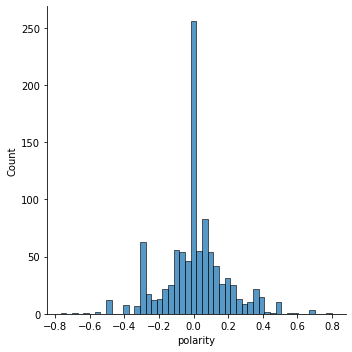

In [22]:
# plot polarity in cfpb_sample using seaborn
sns.displot(cfpb_sample, x="polarity")
plt.show()

What's going on here? Why does sentiment look so close to neutral, or even slightly positive? We know that all of the narratives in this dataset are consumer **complaints**, so we should expect them to look somewhat negative. Let's look at the 5 most positive reviews:

In [23]:
# print the 5 most positive complaints in cfpb_sample
for complaint in cfpb_sample.nlargest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + "\n")

Account reported to my credit report as charge off. DISCOVER representative did not give me an option to settle nor dispute the inaccuracies and should be removed and or updated as I did not have an option to correct it before it affected my credit report greatly.

Ally / Ollo has texted and even called my number after XXXX. I have screenshots as proof of the call after XXXX as well as the text message after XXXX at XXXX on XX/XX/2023 and the call was on XX/XX/2023 at XXXX in violation of the Fair Debt Collection Practices Act.

wisely account put my money on hold for a transaction hold, but they never returned the money, I was sent a check for XXXX XXXX  but my balance was XXXX . Also I was not informed or emailed about the decision and now they won't tell me what happened to my money or my employer.

I have only had two credit cards with XXXX XXXXXXXX and they are currently in good standing. Ive never had any other XXXX XXXXXXXX credit card accounts.

I have been back and forth betwe

Do we have any words that are skewing things? Let's look at the sentiment score for this first comment, and the individual sentiments of the words in it:

In [24]:
sample_complaint = "the company said they are offering a covid relief program which I requested assistance and they are saying a balloon payment is owed in XXXX I called the company and I was told that if I can't make this payment they will be talking taking litigation steps how are people who have lost their job able to keep their homes"
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  0.5
the 0.0
company 0.0
said 0.0
they 0.0
are 0.0
offering 0.0
a 0.0
covid 0.0
relief 0.0
program 0.0
which 0.0
I 0.0
requested 0.0
assistance 0.0
and 0.0
they 0.0
are 0.0
saying 0.0
a 0.0
balloon 0.0
payment 0.0
is 0.0
owed 0.0
in 0.0
XXXX 0.0
I 0.0
called 0.0
the 0.0
company 0.0
and 0.0
I 0.0
was 0.0
told 0.0
that 0.0
if 0.0
I 0.0
can't 0.0
make 0.0
this 0.0
payment 0.0
they 0.0
will 0.0
be 0.0
talking 0.0
taking 0.0
litigation 0.0
steps 0.0
how 0.0
are 0.0
people 0.0
who 0.0
have 0.0
lost 0.0
their 0.0
job 0.0
able 0.5
to 0.0
keep 0.0
their 0.0
homes 0.0


Only one word actually has a sentiment score ("able")! TextBlob's sentiment polarity is not a simple average of all of the sentiments in a string - this is why preprocessing is important and why you should validate these types of off-the-shelf methods. Let's take a look at the most negative reviews and see if these make sense:

In [25]:
# print the 5 most negative complaints in cfpb_sample
for complaint in cfpb_sample.nsmallest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + '\n')

Money is being held with out my permission. Causing me to have pain and suffering for me and my daughter. Horrible customer service and rude employees lie about the policy and does not follow it. I am having a horrible experience with chime and it needs to be resolved.

This company continues to report inaccurate information on my credit report that has brought bad things to my life and ruin my credit. Then when i dispute it and ask for verication or validation on the account i still get kno where with it so this has to stop now.

Someone called my daughter at work trying to get information about me. Never got anything in the mail or they never called me personally.I am very sick and they scared her very much. If they never contacted me and dont even have any information regarding this debt it should be illegal for them to call my daughter when they have never sent me information or called me. This is harassment.

I received my statement I pay the amount in full before the due date my 

In [26]:
sample_complaint = "Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured."
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  -1.0
Navient 0.0
is 0.0
the 0.0
worst -1.0
company 0.0
to 0.0
ever 0.0
exist. 0.0
Website 0.0
does 0.0
not 0.0
work. 0.0
Do 0.0
the 0.0
people 0.0
at 0.0
customer 0.0
service 0.0
even 0.0
work 0.0
for 0.0
navient??? 0.0
They 0.0
don't 0.0
know 0.0
anything 0.0
about 0.0
whats 0.0
going 0.0
on. 0.0
Applied 0.0
for 0.0
a 0.0
repayement 0.0
plan 0.0
and 0.0
their 0.0
website 0.0
always 0.0
says 0.0
an 0.0
error 0.0
has 0.0
occured. 0.0


In this case we have a perfectly negative sentiment (-1.0), but again only one word is contributing - "worst". Sentiment polarity is a powerful tool, but not automatically suited to inference. That being said, maybe it can be helpful for distinguishing between labels. We can take a look at how polarity differs across mortgage and student loans:

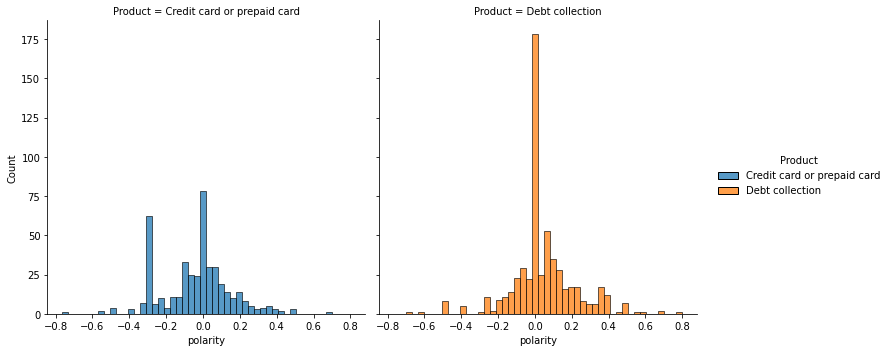

In [27]:
# plot polarity in cfpb_sample by Product
sns.displot(cfpb_sample, x="polarity", hue = "Product", col = "Product")
plt.show()

### Challenge

In addition to sentiment polarity, TextBlob also has a method for determining how "objective" or "subjective" a piece of text is. Plot the objectivity measure by Product. Do these results make sense?

<ipython-input-28-befb9952ab6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfpb_sample['subjectivity'] = cfpb_sample['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


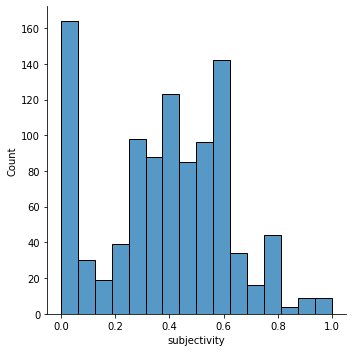

In [28]:
# calculate subjectivity using TextBlob for each complaint in cfpb_sample and save as a column 'subjectivity'
cfpb_sample['subjectivity'] = cfpb_sample['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
# plot subjectivity in cfpb_sample
sns.displot(cfpb_sample, x="subjectivity")
plt.show()

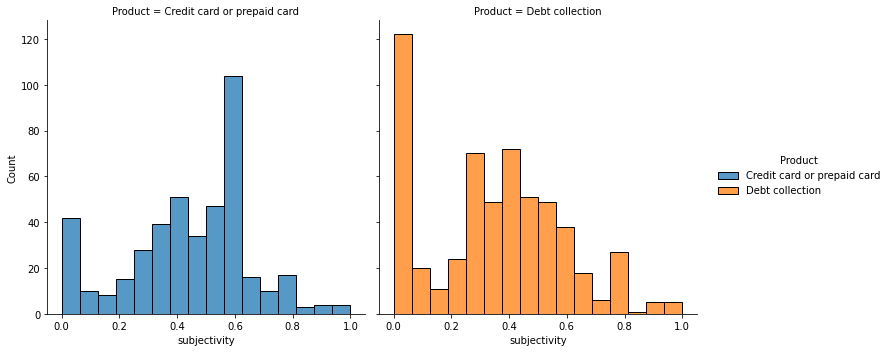

In [29]:
# plot subjectivity in cfpb_sample by Product
sns.displot(cfpb_sample, x="subjectivity", hue = "Product", col = "Product")
plt.show()

# Step 3: Supervised Machine Learning

## Basic Machine Learning Workflow in sklearn

We are almost ready to start making some predictions! We already saw unsupervised learning, and now we will do some supervised learning to predict the "Product category." Supervised learning can be divided into `regression` and `classification`. Regression is used to predict continuous outcomes, while classification is used to predict discrete ones. Let's load our tfidf vectorized dataframe (the commented out code created the data, but takes a long time to run!)

In [30]:
# Take cfpb, turn the 'Product' column into a target variable and binarize, then use the tf_idf matrix as the feature matrix, and split the data into training and testing sets
'''
X = tfidf_vector.fit_transform(cfpb['Consumer complaint narrative'])

# save X to a pickle in data folder
# import pickle
# with open('data/X_train.pkl', 'wb') as f:
#     pickle.dump(X_train, f)
'''
import pickle
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

y = cfpb['Product'].map(lambda x: 1 if x == 'Debt collection' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

We can then train a machine learning model. We'll start with something you may have seen before, the logistic regression:

In [31]:
# train a logistic regression to predict y_train with default hyperparameters
## import LogisticRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression
## initialize LogisticRegression and save as lr
lr = LogisticRegression()
## fit lr to X_train and y_train
lr.fit(X_train, y_train)
## predict y_test from X_test and save as y_pred
y_pred = lr.predict(X_test)

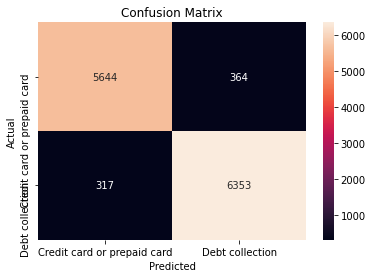

In [32]:
# create y_test and then create a confusion matrix for y_pred and y_test
confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix and name the axes 'Debt collection', 'Credit card or prepaid card' and 'Predicted', 'Actual'. Don't use scientific notation
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Credit card or prepaid card', 'Debt collection'])
ax.yaxis.set_ticklabels(['Credit card or prepaid card', 'Debt collection'])
plt.show()

C:\Users\Anike\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Anike\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'C': 2.782559402207126, 'penalty': 'l2'}
0.9485445718789455


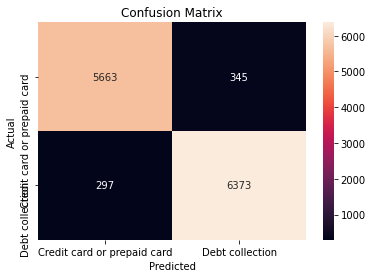

In [33]:
# create a hyperparameter grid for logistic regression checking L1, L2, and Elastic Net regularization and 10 values of C
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': np.logspace(-4, 4, 10)}

# import GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# initialize GridSearchCV with the logistic regression, the hyperparameter grid, and 5-fold cross validation
grid = GridSearchCV(lr, param_grid, cv=5)

# fit grid to X_train and y_train
grid.fit(X_train, y_train)

# print the best hyperparameters
print(grid.best_params_)

# show the best 5 scores
grid.cv_results_['mean_test_score'][0:5]

# print the best score
print(grid.best_score_)

# save the best estimator as best_lr
best_lr = grid.best_estimator_

# confusion matrix for the best estimator, label the axes 'Prediction' and 'Actual' and 'Credit card or prepaid card' and 'Debt collection'
y_pred = best_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Credit card or prepaid card', 'Debt collection'])
ax.yaxis.set_ticklabels(['Credit card or prepaid card', 'Debt collection'])
plt.show()

How did our optimal model do compared to the one without any hyperparameters set? 

### Optional Challenge

Try it yourself! Use logistic regression and the `RandomForestClassifier()` and `GradientBoostingClassifier()` methods 

In [34]:
"""
# create hyperparameter grids for logistic regression, random forest, and gradient boosting
lr_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
rf_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
gb_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'learning_rate': [0.1, 0.5, 1]}

# import GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# initialize GridSearchCV for logistic regression, random forest, and gradient boosting
lr_gs = GridSearchCV(LogisticRegression(), lr_grid)
rf_gs = GridSearchCV(RandomForestClassifier(), rf_grid)
gb_gs = GridSearchCV(GradientBoostingClassifier(), gb_grid)

# fit GridSearchCV for logistic regression, random forest, and gradient boosting
lr_gs.fit(X_train, y_train)
rf_gs.fit(X_train, y_train)
gb_gs.fit(X_train, y_train)

# print the best hyperparameters for logistic regression, random forest, and gradient boosting
print(lr_gs.best_params_)
print(rf_gs.best_params_)
print(gb_gs.best_params_)

# predict y_test from X_test using the best hyperparameters for logistic regression, random forest, and gradient boosting
y_pred_lr = lr_gs.predict(X_test)
y_pred_rf = rf_gs.predict(X_test)
y_pred_gb = gb_gs.predict(X_test)

# create confusion matrices for logistic regression, random forest, and gradient boosting
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_gb = confusion_matrix(y_test, y_pred_gb)

# create heatmaps for logistic regression, random forest, and gradient boosting
sn.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

sn.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

sn.heatmap(cm_gb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
# print the accuracy scores for logistic regression, random forest, and gradient boosting
print(lr_gs.score(X_test, y_test))
print(rf_gs.score(X_test, y_test))
print(gb_gs.score(X_test, y_test))
# print the classification reports for logistic regression, random forest, and gradient boosting
print(classification_report(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_gb))
"""

"\n# create hyperparameter grids for logistic regression, random forest, and gradient boosting\nlr_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}\nrf_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}\ngb_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'learning_rate': [0.1, 0.5, 1]}\n\n# import GridSearchCV from sklearn.model_selection\nfrom sklearn.model_selection import GridSearchCV\n\n# initialize GridSearchCV for logistic regression, random forest, and gradient boosting\nlr_gs = GridSearchCV(LogisticRegression(), lr_grid)\nrf_gs = GridSearchCV(RandomForestClassifier(), rf_grid)\ngb_gs = GridSearchCV(GradientBoostingClassifier(), gb_grid)\n\n# fit GridSearchCV for logistic regression, random forest, and gradient boosting\nlr_gs.fit(X_train, y_train)\nrf_gs.fit(X_train, y_train)\ngb_gs.fit(X_train, y_train)\n\n# print the best hyperparameters for logistic regression, random forest, and gradient boosting\nprint(lr_gs.best_params_)\nprint(rf_gs.best_

# Step 4: Challenge

Do either of the following:

a) Using your own dataset, implement some of the techniques we explored here to featurize text and predict some outcome.

b) Using the CPFB dataset, try running some models that include non-tfidf features. For example, you might use topic weights, sentiment, or objectivity/subjectivity scores. You might also want to include some of the other features in the dataset like whether the complaint was resolved, the issue, and the company involved. We didn't explore how to pre-process categorical data like that for a machine learning pipeline - do you think you could get GPT to show you how to?

## Word2Vec

## Overview <a id='context'></a>

In this part, we will be turning individual words in the data set into vectors, called "Word Embeddings". Word embedding attempt to identify semantic relationships between words by observing them in the context that the word appears. Word2Vec is the most prominent word embedding algorithm.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts.  This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Gram takes a word of interest as its input (e.g. "me") and tries to learn how to predict its context words ("Call","Ishmael"). CBOW does the opposite, taking the context words ("Call","Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

### Word2Vec Features

* `size`: Number of dimensions for word embedding model
* `window`: Number of context words to observe in each direction
* `min_count`: Minimum frequency for words included in model
* `sg` (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram
* `alpha`: Learning rate (initial); prevents model from over-correcting, enables finer tuning
* `iterations`: Number of passes through dataset
* `batch_words`: Number of words to sample from data during each pass


For more detailed background on Word2Vec's mechanics, see this  <a href="https://www.tensorflow.org/versions/r0.8/tutorials/word2vec/index.html">brief tutorial</a> by Google, especially the sections "Motivation," "Skip-Gram Model," and "Visualizing."

We will be using the default value for most of our parameters.











First let's use our handy preprocessing function. Notice that this version will return a list of tokens (not a string), and we also added the `str.lower()` method.

In [35]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    # Individually
    # nlp.Defaults.stop_words.add("XX")
    # nlp.Defaults.stop_words.add("XXXX")
    # nlp.Defaults.stop_words.add("XXXXXXX")
    
    # Using the bitwise |= (or) operator
    nlp.Defaults.stop_words |= {"xx", "xxxx","xxxxxxxx"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text.lower() for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [36]:
cfpb_sample['tokens'] = cfpb_sample['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
cfpb_sample['tokens']

y = cfpb_sample['Product'].map(lambda x: 1 if x == 'Debt collection' else 0)
X = tfidf_vector.fit_transform(cfpb_sample['Consumer complaint narrative'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<ipython-input-36-33feabe9d402>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfpb_sample['tokens'] = cfpb_sample['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
C:\Users\Anike\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Now that we have pre-processed our text, we can use the [`gensim`](https://radimrehurek.com/gensim/) library to construct our word embeddings. We will use the Continous Bag of Words model (CBOW), which predicts target words from its neighboring context words to learn word embeddings from raw text.

Read through the documentation of the Word2Vec method in gensim to understand how to implement the Word2Vec model. Then fill in the blanks so that: we use a __Continuous Bag of Words__ model to create word embeddings of __size 100__ for words that appear in `text` __5 or more times__. We'll set the learning rate to .025, and sample 10000 words from the data during each pass.

In [37]:
model = gensim.models.Word2Vec(cfpb_sample['tokens'], vector_size=100, window=5, 
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

## Embeddings <a id='subsection 2'></a>

Now that we've trained the mode, we can return the actual high-dimensional vector by simply indexing the model with the word as the key:

In [38]:
# New syntax as of gensim 4.0.0
# model['account'] works for 3.8.3
print(model.wv.__getitem__(['account']))

[[-3.14715475e-01  4.08206522e-01  5.74387908e-02 -6.44458458e-02
   5.74738644e-02 -4.20391977e-01  3.21015924e-01  1.01781750e+00
  -1.89478338e-01 -1.60135493e-01 -2.24103466e-01 -6.02432191e-01
   5.26442938e-02  3.19226593e-01  4.85097133e-02 -3.00653905e-01
   1.77203029e-01 -3.72873873e-01 -1.36199743e-01 -8.24676156e-01
   1.48076952e-01  2.26320088e-01  1.39083624e-01 -4.08538073e-01
  -2.66932044e-02  3.15873101e-02 -1.95076883e-01 -3.42211843e-01
  -3.59215051e-01 -8.18232447e-02  4.47064728e-01 -2.83578150e-02
   3.38407583e-03 -9.31987092e-02 -1.20660923e-01  4.89042997e-01
   9.92342383e-02 -2.18596295e-01 -4.13718253e-01 -8.23388934e-01
  -8.77352580e-02 -3.69347334e-01 -5.45076072e-01  9.50749684e-03
   5.69021046e-01 -4.12172914e-01 -3.20977807e-01 -8.45326334e-02
   2.41623223e-01  1.44344524e-01  2.77008861e-01 -4.04406071e-01
   1.40771404e-01  1.19782545e-01 -2.65158325e-01  4.35436189e-01
   3.30632627e-01 -1.60676226e-01 -4.80268478e-01  1.66693538e-01
   2.38286

Check out the shape of the vectors for 'account', what do you notice?

In [39]:
model.wv.__getitem__(['account']).shape

(1, 100)

**Answer**: There are 100 elements in this array. Notice that this was one of the parameters we set in the training process!

Use the following empty cells to look at what the word embeddings look like for words you think may appear in the text! Keep in mind that even if a word shows up in the text as seen above, a word vector will not be created unless it satisfies all conditions we inputted into the model above. 

In [40]:
# word 1
model.wv.__getitem__(['mastercard'])

array([[-0.07717155,  0.0822582 ,  0.01613163, -0.02326364,  0.01406212,
        -0.07537011,  0.07038348,  0.18952598, -0.03885553, -0.0202794 ,
        -0.02429252, -0.11996203,  0.0030416 ,  0.06473441,  0.00740273,
        -0.06488358,  0.03829737, -0.08311107, -0.01891576, -0.15010853,
         0.03791692,  0.0435271 ,  0.018657  , -0.07306442, -0.01814382,
         0.02228811, -0.04378636, -0.06268082, -0.07878757, -0.02347944,
         0.07020906, -0.00913984,  0.01003386, -0.00475954, -0.00679043,
         0.08134016,  0.01468996, -0.05201794, -0.07257448, -0.16218854,
        -0.02871014, -0.06981935, -0.10434671,  0.01138447,  0.10705797,
        -0.07449499, -0.04683118, -0.0196713 ,  0.04167873,  0.02605769,
         0.05781339, -0.08123728,  0.03007264,  0.03940723, -0.05898586,
         0.07244544,  0.06158864, -0.02920198, -0.07905187,  0.03391241,
         0.02602356,  0.01979615, -0.01085984, -0.00361508, -0.11186278,
         0.08772554,  0.05962674,  0.08379869, -0.0

In [41]:
# word 2
model.wv.__getitem__(['company'])

array([[-0.36671907,  0.4390683 ,  0.0398991 , -0.03209729,  0.06856486,
        -0.40283176,  0.42613497,  1.0262927 , -0.19923106, -0.17057632,
        -0.13253635, -0.55274594,  0.06618045,  0.25988886,  0.13501805,
        -0.30514702,  0.15616478, -0.40252241, -0.10689043, -0.7967919 ,
         0.21322358,  0.18927976,  0.17760384, -0.35814196, -0.15538745,
         0.07103369, -0.24346648, -0.3318681 , -0.35999072, -0.1486991 ,
         0.3954018 , -0.15375558,  0.03020141, -0.05706878, -0.01664593,
         0.45382473,  0.05596192, -0.23111129, -0.39265653, -0.7640598 ,
        -0.13977799, -0.2641478 , -0.55628437,  0.01716983,  0.5436617 ,
        -0.32442468, -0.24530898, -0.07029377,  0.22421245,  0.11365146,
         0.31010363, -0.4314815 ,  0.13665712,  0.15541695, -0.32360387,
         0.37452987,  0.33196327, -0.12907986, -0.35662925,  0.20896488,
         0.1799011 ,  0.0708139 , -0.04979523, -0.03589365, -0.59340453,
         0.44802737,  0.2357015 ,  0.45671535, -0.3

`gensim` comes with some handy methods to analyze word relationships. `similarity` will give us a number from 0-1 based on how similar two words are. If this sounds like cosine similarity for words, you'd be right! It just takes the cosine similarity of the high dimensional vectors we input. 

In the following cell, find the similarity between the words `credit` and `debt`:

In [42]:
# New syntax as of gensim 4.0.0
# model.similarity() works as of 3.8.3
model.wv.similarity('credit', 'debt')

0.9512231

We can also find cosine distance between two clusters of word vectors. Each cluster is measured as the mean of its words:

In [43]:
# Similarity between credit/debt and loan/mortgage
model.wv.n_similarity(['credit','debt'],['loan','mortgage'])

0.979055

We can find words that don't belong with `doesnt_match`. It finds the mean vector of the words in the `list`, and identifies the furthest away. Out of the three words in the list `['credit', 'loan', 'student']`, which is the furthest vector from the mean?

In [44]:
# New syntax for 4.0.0 requires passing a tuple ()  a list []
# ['credit', 'loan', 'student'] works for 3.8.3
model.wv.doesnt_match(['credit', 'loan', 'student'])

'credit'

The most famous implementation of this vector math is semantics. What happens if we take:

$$\vec{house} - \vec{rent} + \vec{loan} = $$

In [45]:
model.wv.most_similar(positive=['house', 'loan'], negative=['rent'])

[('come', 0.9976558685302734),
 ('placed', 0.9976382851600647),
 ('evidence', 0.997600793838501),
 ('damages', 0.9976004958152771),
 ('verified', 0.9975975155830383),
 ('try', 0.9975943565368652),
 ('issues', 0.9975736737251282),
 ('believe', 0.997566282749176),
 ('express', 0.9975509643554688),
 ('mortgage', 0.9975406527519226)]

## Text Classification with BERT

In [46]:
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

In [47]:
# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Check the unique labels and their corresponding encoded values
label_encoder.classes_, label_encoder.transform(label_encoder.classes_)

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

**Load the BERT model and tokenizer**

We will use the `transformers` library to load the Legal_BERT model and tokenizer.

In [48]:
# Load the tokenizer and model from Hugging Face
model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

**Part 1: Use Legal_BERT as is for prediction**

In this part, we will use the pre-trained Legal_BERT model without any fine-tuning to predict the labels on the validation set.

In [63]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return self.texts.shape[0]

    def __getitem__(self, item):
        text = self.texts[item].toarray().flatten()  # Convert sparse row to dense array and flatten it
        label = self.labels[item]

        # Convert array to string
        text = ' '.join(map(str, text))

        # Ensure text is a string
        if not isinstance(text, str):
            raise ValueError(f"Expected string but got {type(text)}")

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Use 'max_length' instead of pad_to_max_length
            truncation=True,       # Explicitly set truncation
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Parameters
MAX_LEN = 128
BATCH_SIZE = 16

# Split the data into training and validation sets

train_texts, val_texts, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, MAX_LEN)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Initialize dataset and dataloader
train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, MAX_LEN)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [59]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluation function
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Evaluate the pre-trained model on the validation set
val_acc, val_loss = eval_model(model, train_dataloader, device)
print(f'Validation loss (pre-trained model): {val_loss}')
print(f'Validation accuracy (pre-trained model): {val_acc}')

Validation loss (pre-trained model): 0.6849277147224971
Validation accuracy (pre-trained model): 0.5685714285714286


**Part 2: Fine-tune Legal_BERT and compare the results**

In this part, we will fine-tune the Legal_BERT model on our dataset and then predict the labels on the validation set to compare the results with the pre-trained model.

Fine-tuning involves training the pre-trained model on our specific dataset to adjust the model weights based on our data.

In [64]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training function
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Training loop
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device, scheduler)
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(model, val_dataloader, device)
    print(f'Val loss {val_loss} accuracy {val_acc}')

Epoch 1/3
----------


KeyboardInterrupt: 

## GPT API Approach

First, set up your API Key.

In [65]:
from openai import OpenAI
from pathlib import Path

# # Set the project root directory
# PROJECT_ROOT = Path(path)

# # Function to construct paths relative to the project root
# def project_path(*args):
#     return PROJECT_ROOT.joinpath(*args)

# # Construct the path to the text file
# text_file_path = project_path("scripts", "project_API_key.txt")

# Open and read the text file, saving the content as a string
with open("openai_key.txt", 'r') as file:
    file_text = file.read()  # Read the entire content into a string

client = OpenAI(
  api_key=file_text,
)

Now use the openai API to classify the text.

In [66]:
model_choice = "gpt-4o-mini"

def classify_narrative_zeroshot(narrative):
    response = client.chat.completions.create(
      model=model_choice,
      messages=[
        {
          "role": "system",
          "content": [
            {
              "type": "text",
              "text": "Which of the following product categories is the following text discussing? \n 'Debt collection' or 'Credit card or prepaid card'. Respond only with the name of the category."
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"narrative: '{narrative}'"
            }
          ]
        }
      ],
      temperature=0,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    return response.choices[0].message.content

In [67]:
text = cfpb['Consumer complaint narrative']
labels = cfpb['Product']

In [68]:
sample_text = text[1:100]
sample_labels = labels[1:100]

In [69]:
# Get predictions
classifications = sample_text.apply(classify_narrative_zeroshot)

# Evaluate the model
print(f"{model_choice} Performance:")
print(classification_report(sample_labels, classifications))
print("Accuracy:", round(accuracy_score(sample_labels, classifications),2))

APIConnectionError: Connection error.

This was the performance on zero-shot prompting. Now let's try one shot.

In [57]:
model_choice = "gpt-4o-mini"

example_card = "My credit card application was denied"
example_debt = "This debt is from over XXXX ago"

def classify_narrative_oneshot(narrative):
    response = client.chat.completions.create(
      model=model_choice,
      messages=[
        {
          "role": "system",
          "content": [
            {
              "type": "text",
              "text": f"This complaint is about debt collection: {example_debt} and this is about credit cards: {example_card} \nWhich of the following product categories is the following text discussing? \n 'Debt collection' or 'Credit card or prepaid card'. Respond only with the name of the category."
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"narrative: '{narrative}'"
            }
          ]
        }
      ],
      temperature=0,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0
    )

    return response.choices[0].message.content

In [58]:
# Get predictions
classifications = sample_text.apply(classify_narrative_oneshot)

# Evaluate the model
print(f"{model_choice} Performance:")
print(classification_report(sample_labels, classifications))
print("Accuracy one-shot:", round(accuracy_score(sample_labels, classifications),2))

APIConnectionError: Connection error.

Seems like we did better with zero-shot! Any ideas why?

# Future Directions

We've covered some basics today, but here are some future steps you might take:

* **Acquiring Data**: Working with web scrapers, APIs etc. to get structured text data.
* **Preprocessing**: We did some basic pre-processing of text data, but there are other factors to consider like creating categorical dummies, scaling certain features, and doing some ex ante feature selection with methods like correlation plots.
* **Regression**: We did a bit of classification, but some problems will require that you predict a continuous target and there are different techniques and metrics to go with this.
* **Deep Learning**: We covered some basic classification algorithms, but neural nets are a powerful tool for making better classifications, especially with complex data like text or images.
* **AutoML**: In practice, machine learning requires running hundreds or thousands of models to find the best one. AutoML libraries such as TPOT can help automate the process searching for the best model.